In [1]:
%cd ../
!pwd

/home/yoshio/git/second.pytorch
/home/yoshio/git/second.pytorch


In [2]:
import os
import pickle
from pathlib import Path
from functools import partial
import re
import json

import numpy as np
from scipy.special import logit, expit
from sklearn.model_selection import KFold
from sklearn.metrics import brier_score_loss, precision_score
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import torch

In [3]:
def expected_calibration_error(y_true, y_prob, n_bins):
    bins = np.linspace(0., 1., n_bins + 1, endpoint=True)
    binids = np.digitize(y_prob, bins) - 1
    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))

    nonzero = bin_total != 0
    acc = bin_true[nonzero] / bin_total[nonzero]
    conf = bin_sums[nonzero] / bin_total[nonzero]
    return np.sum(np.abs(acc - conf) * bin_total[nonzero]) / bin_total.sum()

In [4]:
KITTI_INFO = Path(os.environ.get("KITTI_INFO", "/hdd/kitti/kitti_infos_val.pkl"))
CONF = os.environ.get("CONF", "pointpillars/car/xyres_16-onecycle.config")
MODEL = os.environ.get("MODEL", "pointpillars-car-16-onecycle")
print(KITTI_INFO, CONF, MODEL)

MODEL_DIR = Path(f"./model/{MODEL}")
checkpoint_json = json.loads((MODEL_DIR / "checkpoints.json").read_text())
GSTEP = int(re.search(r"voxelnet-(\d+)\.tckpt", checkpoint_json["latest_ckpt"]["voxelnet"]).group(1))
print("latest step:", GSTEP)

RAWDATA = Path(f"./model/{MODEL}/eval_results/step_{GSTEP}/detections_kitti.pkl")
DATA = Path(f"./model/{MODEL}/eval_results/step_{GSTEP}/result_kitti.pkl")
MODEL_WEIGHT = MODEL_DIR / f"voxelnet-{GSTEP}.tckpt"

/hdd/kitti/kitti_infos_val.pkl pointpillars/car/xyres_16-nonelim-onecycle.config pointpillars-car-xyres_16-nonelim-onecycle
latest step: 92800


In [5]:
with KITTI_INFO.open("rb") as f:
    gts = pickle.load(f)

with RAWDATA.open("rb") as f:
    rawdets = pickle.load(f)

with DATA.open("rb") as f:
    dets = pickle.load(f)

In [6]:
assert(np.all([np.allclose(_dets["score"], _rawdets["score"]) for _dets, _rawdets in zip(dets, rawdets)]))

# Conditional Calibration of KITTI Dataset Car difficulty:2 3DIoU@0.70

In [7]:
data = {
    "y_true": [],
    "conf": [],
    "X": [],
    "Y": [],
    "Z": [],
    "num_points_in_det": [],
    "sample_idx": [],
}

for i, (det, gt) in enumerate(tqdm(zip(dets, gts), total=len(dets))):
    result = det["official/3d_0.70/2/bin"]
    mask = result != 0 # remove 'ignore' detections
    data["y_true"].append(np.where(result[mask] == 1, 1, 0))
    data["conf"].append(det["score"][mask])
    data["X"].append(det["location"][mask,0])
    data["Y"].append(det["location"][mask,1])
    data["Z"].append(det["location"][mask,2])
    data["num_points_in_det"].append(det["num_points_in_det"][mask])
    data["sample_idx"].append(np.full(mask.sum(), i))

df = pd.DataFrame({key: np.concatenate(val) for key, val in data.items()})

  0%|          | 0/3769 [00:00<?, ?it/s]

In [8]:
df["sqrt_points"] = np.sqrt(df.num_points_in_det)
df["distance"] = np.sqrt(df.X ** 2 + df.Z ** 2)
df["angle"] = np.arctan2(df.X, df.Z)
df.head()

,y_true,conf,X,Y,Z,num_points_in_det,sample_idx,sqrt_points,distance,angle
0,0,0.240973,-24.963131,2.426588,34.651762,77,0,8.774964,42.707172,-0.624286
1,0,0.219316,7.163721,1.521565,29.341207,16,0,4.000000,30.203068,0.239467
2,0,0.174185,0.218019,0.785343,34.297404,0,0,0.000000,34.298097,0.006357
3,0,0.118859,8.063473,1.543345,28.299917,6,0,2.449490,29.426262,0.277574
4,0,0.115192,-20.043210,2.296953,39.461959,19,0,4.358899,44.260326,-0.469957


## EDA

### Hist of gt positions

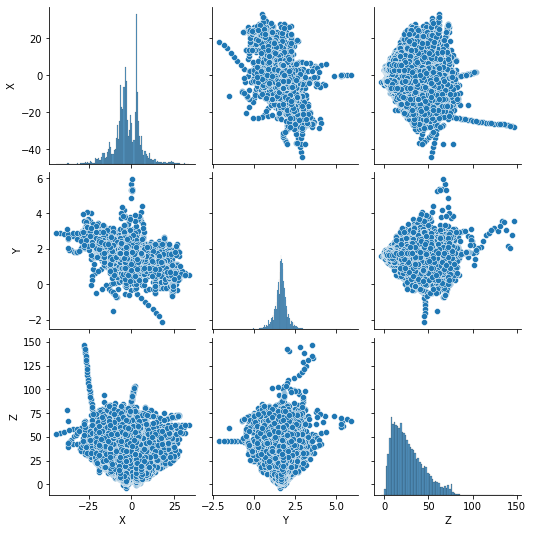

In [9]:
gt_data = {
    "X": [],
    "Y": [],
    "Z": [],
    "points": [],
}

for g in gts:
    mask = g["annos"]["index"] >= 0
    gt_data["X"].append(g["annos"]["location"][mask, 0])
    gt_data["Y"].append(g["annos"]["location"][mask, 1])
    gt_data["Z"].append(g["annos"]["location"][mask, 2])
    gt_data["points"].append(g["annos"]["num_points_in_gt"][mask])

gt_df = pd.DataFrame({key: np.concatenate(val) for key, val in gt_data.items()})
sns.pairplot(gt_df[["X", "Y", "Z"]])
plt.show()

In [10]:
gt_df["angle"] = np.arctan2(gt_df.X, gt_df.Z)
gt_df["angle_deg"] = np.arctan2(gt_df.X, gt_df.Z) * 180 / np.pi

gt_df.describe()

,X,Y,Z,points,angle,angle_deg
count,20870.000000,20870.000000,20870.000000,20870.000000,20870.000000,20870.000000
mean,-2.207046,1.647513,27.297164,177.576761,-0.081177,-4.651102
std,7.436291,0.435298,17.863289,300.082992,0.349523,20.026215
min,-44.030000,-2.140000,-3.550000,0.000000,-2.369033,-135.735569
25%,-6.180000,1.460000,13.282500,21.000000,-0.308833,-17.694823
50%,-2.840000,1.660000,23.460000,64.000000,-0.093162,-5.337793
75%,2.760000,1.850000,37.940000,206.000000,0.128844,7.382206
max,33.400000,5.930000,146.850000,4874.000000,1.778852,101.920739


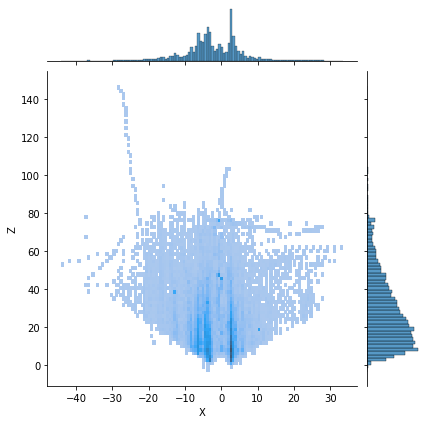

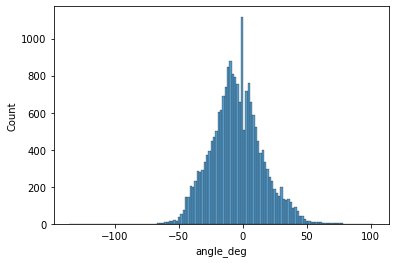

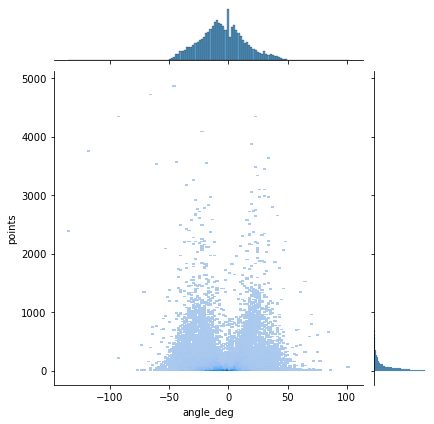

In [11]:
sns.jointplot(data=gt_df, x="X", y="Z", kind="hist")
plt.show()
sns.histplot(x=gt_df.angle_deg)
plt.show()
sns.jointplot(data=gt_df, x="angle_deg", y="points", kind="hist")
plt.show()

### hist of det locations

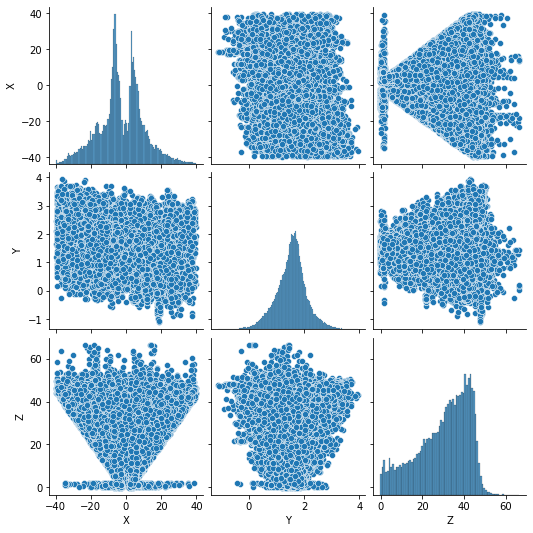

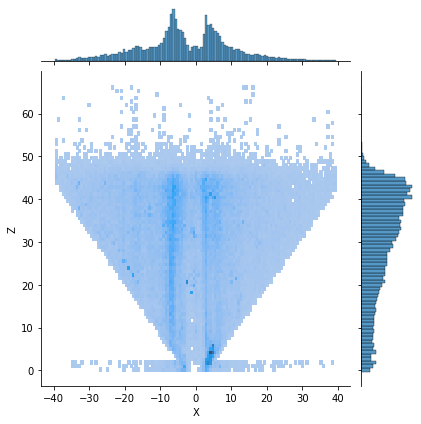

In [12]:
sns.pairplot(df[["X", "Y", "Z"]])
plt.show()

sns.jointplot(data=df, x="X", y="Z", kind="hist")
plt.show()

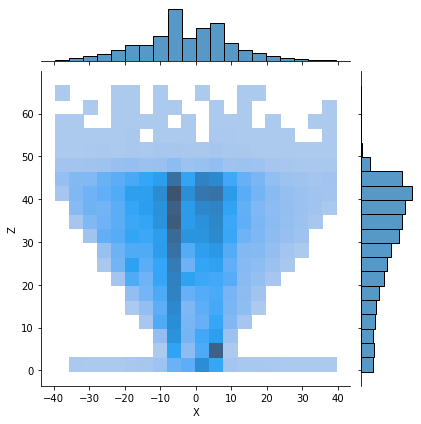

In [13]:
sns.jointplot(data=df, x="X", y="Z", kind="hist", bins=20, marginal_kws={"bins": 20})

### hist of num_points

2673


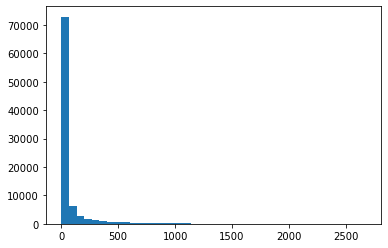

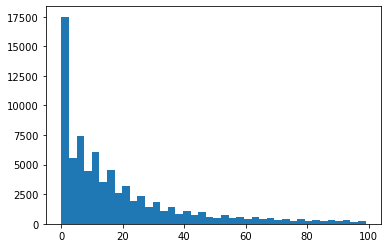

In [14]:
num_points_in_det = df.num_points_in_det.to_numpy()
print(num_points_in_det.max())
plt.hist(num_points_in_det, bins=40)
plt.show()

plt.hist(num_points_in_det[num_points_in_det < 100], bins=40)
plt.show()

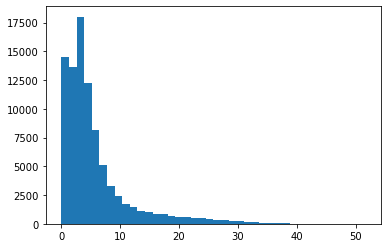

In [15]:
plt.hist(df.sqrt_points.to_numpy(), bins=40)
plt.show()

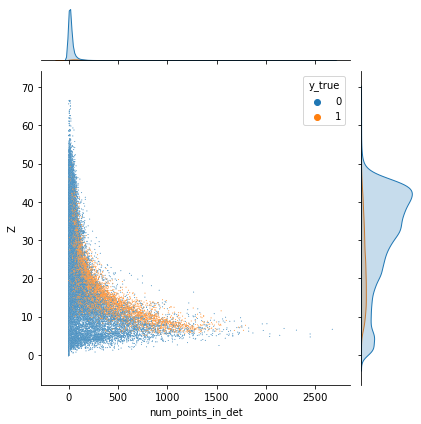

In [16]:
sns.jointplot(data=df, x="num_points_in_det", y="Z", hue="y_true", joint_kws={"s": 1})

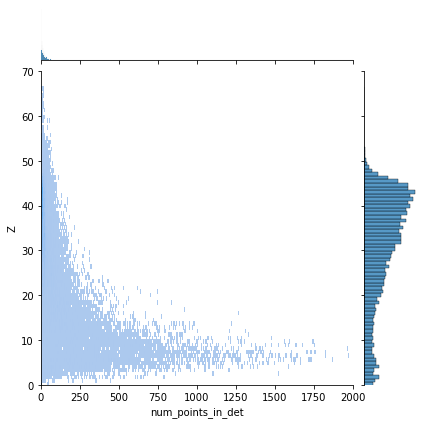

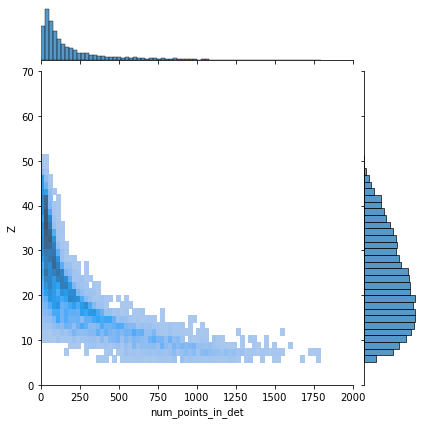

In [17]:
sns.jointplot(data=df[df.y_true == 0], x="num_points_in_det", y="Z", kind="hist",
	ylim=(0, 70), xlim=(0, 2000))
sns.jointplot(data=df[df.y_true == 1], x="num_points_in_det", y="Z", kind="hist",
	ylim=(0, 70), xlim=(0, 2000))
plt.show()

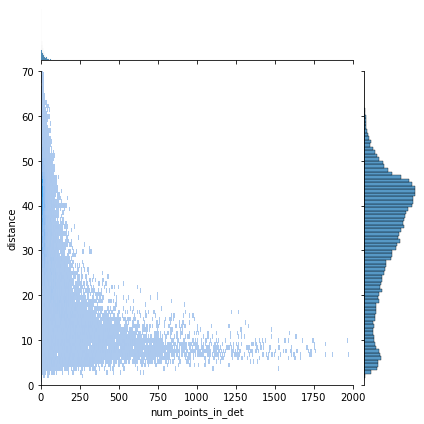

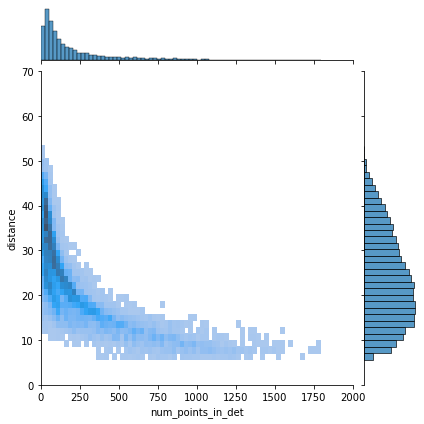

In [18]:
sns.jointplot(data=df[df.y_true == 0], x="num_points_in_det", y="distance", kind="hist",
	ylim=(0, 70), xlim=(0, 2000))
sns.jointplot(data=df[df.y_true == 1], x="num_points_in_det", y="distance", kind="hist",
	ylim=(0, 70), xlim=(0, 2000))
plt.show()

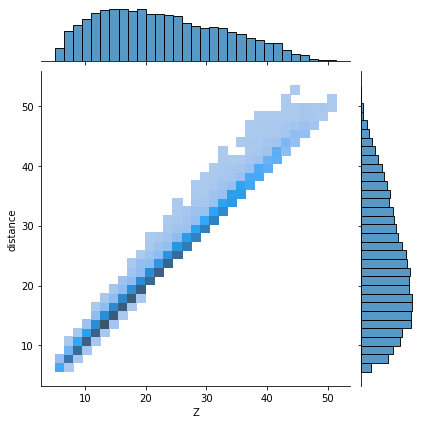

In [19]:
sns.jointplot(data=df[df.y_true == 1], x="Z", y="distance", kind="hist")

## D-ECE

<BarContainer object of 20 artists>

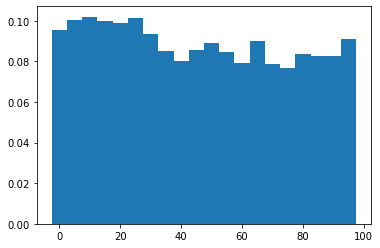

In [20]:
n_pbins = 20
pbins = np.linspace(0, 100, n_pbins+1, endpoint=True)
pbinids = np.digitize(num_points_in_det, pbins) - 1

dece = [expected_calibration_error(df.y_true[pbinids == i], df.conf[pbinids == i], n_bins=15) for i in range(n_pbins)]
plt.bar(pbins[:-1], dece, width=pbins[1]-pbins[0])

<BarContainer object of 10 artists>

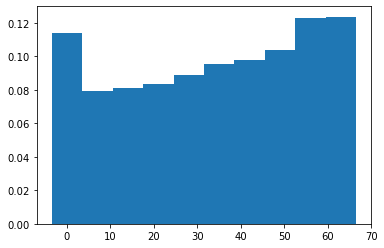

In [21]:
n_zbins = 10
zbins = np.linspace(0, 70, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.Z.to_numpy(), zbins) - 1

dece = [expected_calibration_error(df.y_true[zbinids == i], df.conf[zbinids == i], n_bins=15) for i in range(n_zbins)]
plt.bar(zbins[:-1], dece, width=zbins[1]-zbins[0])

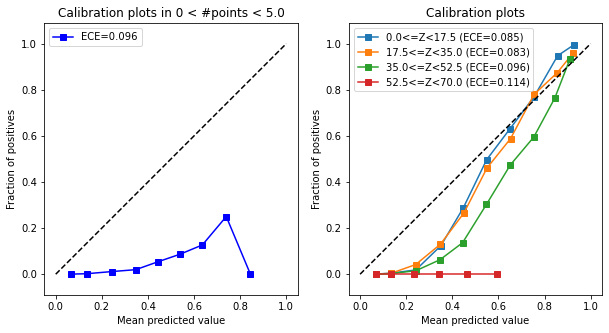

In [22]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
prob_true, prob_pred = calibration_curve(df.y_true[pbinids == 0], df.conf[pbinids == 0], n_bins=10)
ece = expected_calibration_error(df.y_true[pbinids == 0], df.conf[pbinids == 0], n_bins=10)
plt.title(f"Calibration plots in 0 < #points < {pbins[1]}")
plt.plot(prob_pred, prob_true, "bs-", label="ECE=%.3f"%ece)
plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend()

plt.plot([0,1], [0,1], "k--")
plt.axis("equal")

plt.subplot(1,2,2)
n_zbins = 4
zbins = np.linspace(0, 70, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.Z.to_numpy(), zbins) - 1
plt.title(f"Calibration plots")
for zi in range(n_zbins):
    prob_true, prob_pred = calibration_curve(df.y_true[zbinids == zi], df.conf[zbinids == zi], n_bins=10)
    ece = expected_calibration_error(df.y_true[zbinids == zi], df.conf[zbinids == zi], n_bins=10)
    plt.plot(prob_pred, prob_true, "s-", label="%.1f<=Z<%.1f (ECE=%.3f)"%(zbins[zi], zbins[zi+1], ece))
plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend()

plt.plot([0,1], [0,1], "k--")
plt.axis("equal")
plt.show()

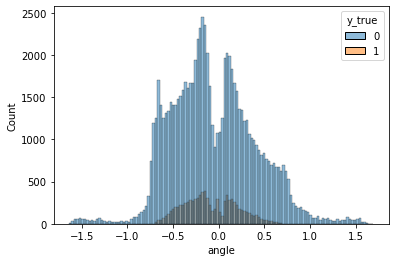

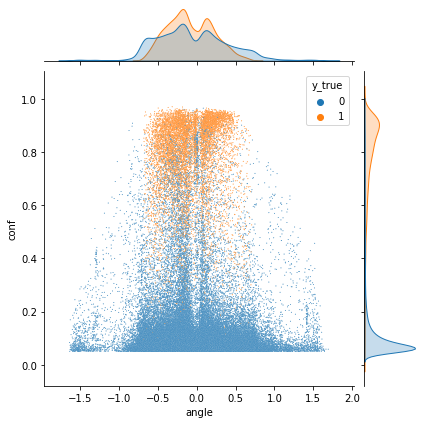

In [23]:
sns.histplot(data=df, x="angle", hue="y_true")
sns.jointplot(data=df, x="angle", y="conf", hue="y_true", joint_kws={"s": 1}, marginal_kws={"common_norm": False})

In [24]:
ece_data = {
    "method": [],
    "angle": [],
    "ECE": [],
}

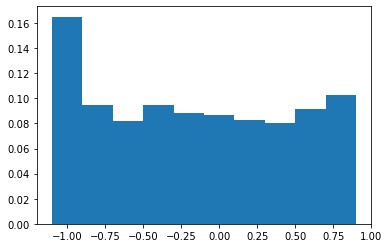

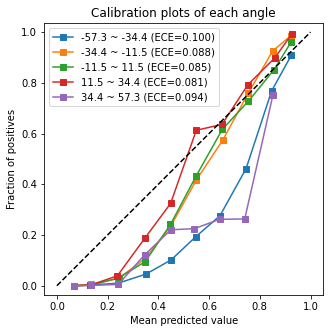

In [25]:
n_zbins = 10
zbins = np.linspace(-1.0, 1.0, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.angle, zbins) - 1

dece = [expected_calibration_error(df.y_true[zbinids == i], df.conf[zbinids == i], n_bins=15) for i in range(n_zbins)]
zbins_total = np.bincount(zbinids.clip(0, n_zbins-1), minlength=n_zbins)
dece_mean = np.sum(np.array(dece) * zbins_total) / zbins_total.sum()
plt.bar(zbins[:-1], dece, width=zbins[1]-zbins[0])
plt.show()

plt.figure(figsize=(5,5))
n_zbins = 5
zbins = np.linspace(-1.0, 1.0, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.angle, zbins) - 1
plt.title(f"Calibration plots of each angle")
for zi in range(n_zbins):
    prob_true, prob_pred = calibration_curve(df.y_true[zbinids == zi], df.conf[zbinids == zi], n_bins=10)
    ece = expected_calibration_error(df.y_true[zbinids == zi], df.conf[zbinids == zi], n_bins=10)
    plt.plot(prob_pred, prob_true, "s-", label="%.1f ~ %.1f (ECE=%.3f)"%(zbins[zi]/np.pi*180, zbins[zi+1]/np.pi*180, ece))
    ece_data["method"].append("baseline")
    ece_data["angle"].append("%.1f ~ %.1f" % (zbins[zi]/np.pi*180, zbins[zi+1]/np.pi*180))
    ece_data["ECE"].append(ece)
ece_data["method"].append("baseline")
ece_data["angle"].append("D-ECE")
ece_data["ECE"].append(dece_mean)

plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend()
plt.plot([0,1], [0,1], "k--")
plt.axis("equal")
plt.show()


What?!
lidarなのにカメラ画面端のcalibrationが悪化している

おそらくトレーニング・推論時に画面外の点群を削除してから推論を回しているため。
→画面外削除をせずに推論してから後処理すべきでは？

In [26]:
CV = 3

kf = KFold(CV, shuffle=False)
X = np.arange(df.sample_idx.max()+1)
calibed_true = []
calibed_pred = []
indices = []

for train_idx, val_idx in kf.split(X, X):
    trainset = df[df.sample_idx.isin(train_idx)]
    valset = df[df.sample_idx.isin(val_idx)]
    indices.append(valset.index.to_numpy())
    calibed_true.append(valset.y_true.to_numpy())

    X_train = logit(trainset.conf.to_numpy().reshape(-1, 1))
    X_val = logit(valset.conf.to_numpy().reshape(-1, 1))
    y_train = trainset.y_true.to_numpy()
    y_val = valset.y_true.to_numpy()

    inst = LogisticRegression(random_state=0).fit(X_train, y_train)
    calibed_pred.append(inst.predict_proba(X_val)[:,1])

calibed_true = np.concatenate(calibed_true)
calibed_pred = np.concatenate(calibed_pred)
indices = np.concatenate(indices)
assert np.all(indices == np.arange(len(df)))

df["conf_platt"] = calibed_pred

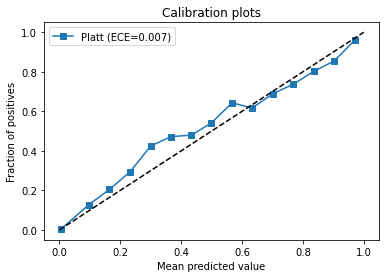

In [27]:
prob_true, prob_pred = calibration_curve(calibed_true, calibed_pred, n_bins=15)
ece = expected_calibration_error(calibed_true, calibed_pred, 15)
plt.title("Calibration plots")
plt.plot(prob_pred, prob_true, "s-", label="Platt (ECE=%.3f)"%ece)
plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend()
plt.plot([0,1], [0,1], "k--")
plt.show()

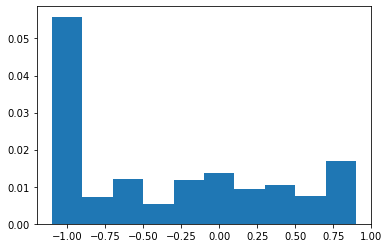

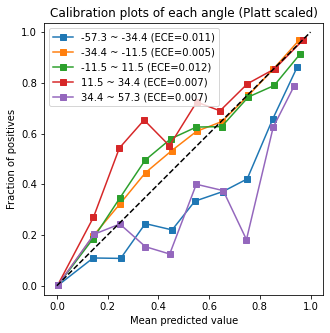

In [28]:
n_zbins = 10
zbins = np.linspace(-1.0, 1.0, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.angle, zbins) - 1

dece = [expected_calibration_error(df.y_true[zbinids == i], df.conf_platt[zbinids == i], n_bins=15) for i in range(n_zbins)]
zbins_total = np.bincount(zbinids.clip(0, n_zbins-1), minlength=n_zbins)
dece_mean = np.sum(np.array(dece) * zbins_total) / zbins_total.sum()
plt.bar(zbins[:-1], dece, width=zbins[1]-zbins[0])
plt.show()

plt.figure(figsize=(5,5))
n_zbins = 5
zbins = np.linspace(-1.0, 1.0, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.angle, zbins) - 1
plt.title(f"Calibration plots of each angle (Platt scaled)")
for zi in range(n_zbins):
    prob_true, prob_pred = calibration_curve(df.y_true[zbinids == zi], df.conf_platt[zbinids == zi], n_bins=10)
    ece = expected_calibration_error(df.y_true[zbinids == zi], df.conf_platt[zbinids == zi], n_bins=10)
    plt.plot(prob_pred, prob_true, "s-", label="%.1f ~ %.1f (ECE=%.3f)"%(zbins[zi]/np.pi*180, zbins[zi+1]/np.pi*180, ece))
    ece_data["method"].append("Platt scaling")
    ece_data["angle"].append("%.1f ~ %.1f" % (zbins[zi]/np.pi*180, zbins[zi+1]/np.pi*180))
    ece_data["ECE"].append(ece)
ece_data["method"].append("Platt scaling")
ece_data["angle"].append("D-ECE")
ece_data["ECE"].append(dece_mean)

plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend()
plt.plot([0,1], [0,1], "k--")
plt.axis("equal")
plt.show()


### Conditional Platt Scaling

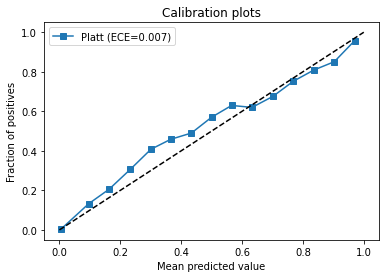

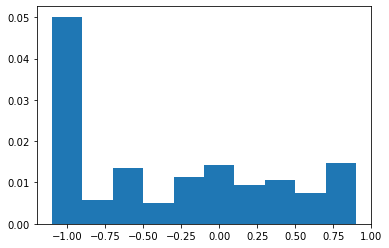

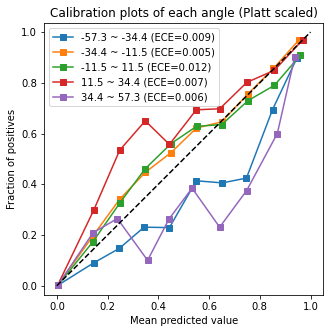

In [29]:
CV = 3

kf = KFold(CV, shuffle=False)
X = np.arange(df.sample_idx.max()+1)
calibed_true = []
calibed_pred = []
indices = []

for train_idx, val_idx in kf.split(X, X):
    trainset = df[df.sample_idx.isin(train_idx)]
    valset = df[df.sample_idx.isin(val_idx)]
    indices.append(valset.index.to_numpy())
    calibed_true.append(valset.y_true.to_numpy())

    X_train = np.vstack([logit(trainset.conf.to_numpy()), np.abs(trainset.angle.to_numpy())]).T
    X_val = np.vstack([logit(valset.conf.to_numpy()), np.abs(valset.angle.to_numpy())]).T
    y_train = trainset.y_true.to_numpy()
    y_val = valset.y_true.to_numpy()

    inst = LogisticRegression(random_state=0).fit(X_train, y_train)
    calibed_pred.append(inst.predict_proba(X_val)[:,1])

calibed_true = np.concatenate(calibed_true)
calibed_pred = np.concatenate(calibed_pred)
indices = np.concatenate(indices)
assert np.all(indices == np.arange(len(df)))

df["conf_platt_cond"] = calibed_pred

prob_true, prob_pred = calibration_curve(calibed_true, calibed_pred, n_bins=15)
ece = expected_calibration_error(calibed_true, calibed_pred, 15)
plt.title("Calibration plots")
plt.plot(prob_pred, prob_true, "s-", label="Platt (ECE=%.3f)"%ece)
plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend()
plt.plot([0,1], [0,1], "k--")
plt.show()


n_zbins = 10
zbins = np.linspace(-1.0, 1.0, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.angle, zbins) - 1

dece = [expected_calibration_error(df.y_true[zbinids == i], df.conf_platt_cond[zbinids == i], n_bins=15) for i in range(n_zbins)]
zbins_total = np.bincount(zbinids.clip(0, n_zbins-1), minlength=n_zbins)
dece_mean = np.sum(np.array(dece) * zbins_total) / zbins_total.sum()
plt.bar(zbins[:-1], dece, width=zbins[1]-zbins[0])
plt.show()

plt.figure(figsize=(5,5))
n_zbins = 5
zbins = np.linspace(-1.0, 1.0, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.angle, zbins) - 1
plt.title(f"Calibration plots of each angle (Platt scaled)")
for zi in range(n_zbins):
    prob_true, prob_pred = calibration_curve(df.y_true[zbinids == zi], df.conf_platt_cond[zbinids == zi], n_bins=10)
    ece = expected_calibration_error(df.y_true[zbinids == zi], df.conf_platt_cond[zbinids == zi], n_bins=10)
    plt.plot(prob_pred, prob_true, "s-", label="%.1f ~ %.1f (ECE=%.3f)"%(zbins[zi]/np.pi*180, zbins[zi+1]/np.pi*180, ece))
    ece_data["method"].append("Platt scaling (w/ abs(angle))")
    ece_data["angle"].append("%.1f ~ %.1f" % (zbins[zi]/np.pi*180, zbins[zi+1]/np.pi*180))
    ece_data["ECE"].append(ece)
ece_data["method"].append("Platt scaling (w/ abs(angle))")
ece_data["angle"].append("D-ECE")
ece_data["ECE"].append(dece_mean)

plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend()
plt.plot([0,1], [0,1], "k--")
plt.axis("equal")
plt.show()

In [30]:
ece_df = pd.DataFrame(ece_data)
indices = ece_df["method"].unique()
cols = ece_df["angle"].unique()

ece_df.pivot(index="method", columns="angle", values="ECE").loc[indices, cols]

angle,-57.3 ~ -34.4,-34.4 ~ -11.5,-11.5 ~ 11.5,11.5 ~ 34.4,34.4 ~ 57.3,D-ECE
method,,,,,,
baseline,0.100249,0.087636,0.085347,0.081105,0.094002,0.089617
Platt scaling,0.011184,0.004984,0.011773,0.006780,0.007028,0.011000
Platt scaling (w/ abs(angle)),0.009265,0.005439,0.011895,0.007087,0.006096,0.010878


## mIOU

In [31]:
y_true = df.y_true
X = np.vstack([logit(df.conf.to_numpy()), np.abs(df.angle.to_numpy())]).T

RAWDATA = Path(f"./model/{MODEL}/eval_results/step_{GSTEP}/detections_kitti.pkl")

with RAWDATA.open("rb") as f:
    detections = pickle.load(f)

platt = LogisticRegression(random_state=0).fit(X, y_true)
for det in tqdm(detections):
    angle = np.arctan2(det["location"][:,0], det["location"][:,2])
    testX = np.vstack([logit(det["score"]), np.abs(angle)]).T
    if len(testX) == 0:
        continue
    det["score"] = platt.predict_proba(testX)[:,1]
    arg = np.argsort(det["score"])[::-1]
    for key in det.keys():
        if key == "metadata":
            continue
        det[key] = det[key][arg]

OUTPUT_POST_DIR = Path(f"./model/{MODEL}/condcalib_absangle/eval_results/step_{GSTEP}")
OUTPUT_POST_DIR.mkdir(exist_ok=True, parents=True)

with (OUTPUT_POST_DIR / "detections_kitti.pkl").open("wb") as f:
    pickle.dump(detections, f)

  0%|          | 0/3769 [00:00<?, ?it/s]

In [32]:
command = f"docker run --rm -it --gpus all \
		-v /hdd/kitti:/app/data \
		-v $PWD/model:/app/model \
		second.pytorch:latest \
		python ./pytorch/train.py evaluate_from_result \
			--config_path=./configs/{CONF} \
			--result_path_step=/app/model/{MODEL}/condcalib_absangle/eval_results/step_{GSTEP} \
			--measure_time=True \
			--use_detections_kitti=True \
			--batch_size=1"
!bash -c "{command}"

/usr/local/lib/python3.9/dist-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_CUDA_DRIVER=/usr/lib/x86_64-linux-gnu/libcuda.so.

For more information about alternatives visit: ('https://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('https://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignor

In [33]:
def show_calibration(y_true, y_pred, n_bins=15):
    plt.figure(figsize=(10, 5))
    plt.suptitle("KITTI Dataset Car difficulty:2 3DIoU@0.70")
    plt.subplot(1,2,1)
    plt.title("Raw predicted value")
    plt.hist(y_pred, range=(0, 1), bins=n_bins)
    plt.xlabel("Predicted value")
    plt.ylabel("Count")
    
    plt.subplot(1,2,2)
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=n_bins)
    ece = expected_calibration_error(y_true, y_pred, n_bins=n_bins)
    plt.title("Raw Calibration plots")
    plt.plot(prob_pred, prob_true, "bs-", label="ECE=%.3f"%ece)
    plt.xlim(-0.05, 1.05)
    plt.xlabel("Mean predicted value")
    plt.ylabel("Fraction of positives")
    plt.legend()
    
    plt.plot([0,1], [0,1], "k--")
    plt.show()

  0%|          | 0/3769 [00:00<?, ?it/s]

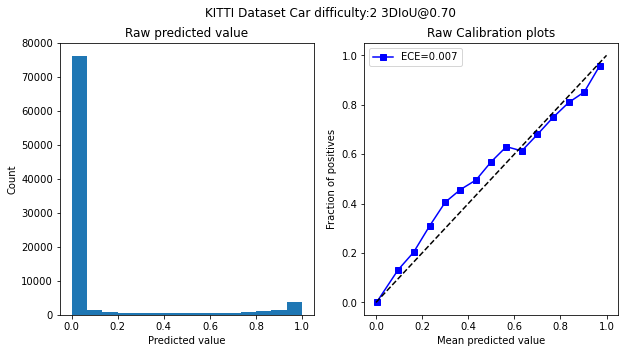

,ECE,D-ECE,Easy 3DIoU@0.7,Moderate 3DIoU@0.7,Hard 3DIoU@0.7
method,,,,,
baseline,0.087506,0.089617,84.50,74.58,68.85
Platt scaling w/abs(angle),0.006959,0.010272,84.59,74.53,68.80


In [34]:
import re

with (OUTPUT_POST_DIR / "result_kitti.pkl").open("rb") as f:
    dets_calib = pickle.load(f)

cy_true_li = []
cy_pred_li = []

for det in tqdm(dets_calib):
    result = det["official/3d_0.70/2/bin"]
    mask = result != 0 # remove 'ignore' detections
    cy_true_li.append(np.where(result[mask] == 1, 1, 0))
    cy_pred_li.append(det["score"][mask])

cy_true = np.concatenate(cy_true_li)
cy_pred = np.concatenate(cy_pred_li)

show_calibration(cy_true, cy_pred)

with (MODEL_DIR / f"eval_results/step_{GSTEP}/result_evaluation.pkl").open("rb") as f:
    result = pickle.load(f)

with (OUTPUT_POST_DIR / "result_evaluation.pkl").open("rb") as f:
    result_calib = pickle.load(f)

match = re.search(r"AP:([\d\.]+), ([\d\.]+), ([\d\.]+)", result["official"].split("\n")[3])
match_calib = re.search(r"AP:([\d\.]+), ([\d\.]+), ([\d\.]+)", result_calib["official"].split("\n")[3])

n_zbins = 10
zbins = np.linspace(-1.0, 1.0, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.angle, zbins) - 1
zbins_total = np.bincount(zbinids.clip(0, n_zbins-1), minlength=n_zbins)
dece = [expected_calibration_error(df.y_true[zbinids == i], df.conf[zbinids == i], n_bins=15) for i in range(n_zbins)]
dece_mean = np.sum(np.array(dece) * zbins_total) / zbins_total.sum()
cdece = [expected_calibration_error(cy_true[zbinids == i], cy_pred[zbinids == i], n_bins=15) for i in range(n_zbins)]
cdece_mean = np.sum(np.array(cdece) * zbins_total) / zbins_total.sum()

df = pd.DataFrame({
    "method": ["baseline", "Platt scaling w/abs(angle)"],
    "ECE": [expected_calibration_error(df.y_true, df.conf, 15), expected_calibration_error(cy_true, cy_pred, 15)],
    "D-ECE": [dece_mean, cdece_mean],
    "Easy 3DIoU@0.7": [match.group(1), match_calib.group(1)],
    "Moderate 3DIoU@0.7": [match.group(2), match_calib.group(2)],
    "Hard 3DIoU@0.7": [match.group(3), match_calib.group(3)],
})
df.set_index("method")